In [1]:
%load_ext autotime
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from core.tools.data_import import *
from core.tools.time_series import *
from constants import *

time: 188 ms


In [3]:
df = load_dataset(UNRATE_DIR["EC2"])
df_d1 = differencing(df, periods=1, order=1)

lags = list(range(1, 25))
X_FEATURES = len(lags)
X, y = gen_supervised(df_d1, predictors=lags)
X, y = clean_nan(X, y)

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64
25 (2.94%) observations with Nan are dropped.
time: 28.3 ms


In [4]:
X.head()

,UNRATE_od1_pd1_lag1,UNRATE_od1_pd1_lag2,UNRATE_od1_pd1_lag3,UNRATE_od1_pd1_lag4,UNRATE_od1_pd1_lag5,UNRATE_od1_pd1_lag6,UNRATE_od1_pd1_lag7,UNRATE_od1_pd1_lag8,UNRATE_od1_pd1_lag9,UNRATE_od1_pd1_lag10,...,UNRATE_od1_pd1_lag15,UNRATE_od1_pd1_lag16,UNRATE_od1_pd1_lag17,UNRATE_od1_pd1_lag18,UNRATE_od1_pd1_lag19,UNRATE_od1_pd1_lag20,UNRATE_od1_pd1_lag21,UNRATE_od1_pd1_lag22,UNRATE_od1_pd1_lag23,UNRATE_od1_pd1_lag24
DATE,,,,,,,,,,,,,,,,,,,,,
1950-02-01,-0.1,0.2,-1.5,1.3,-0.2,0.1,0.5,0.1,0.8,0.3,...,0.1,-0.1,-0.1,0.3,0.0,0.1,-0.4,-0.1,0.2,0.4
1950-03-01,-0.1,-0.1,0.2,-1.5,1.3,-0.2,0.1,0.5,0.1,0.8,...,0.2,0.1,-0.1,-0.1,0.3,0.0,0.1,-0.4,-0.1,0.2
1950-04-01,-0.1,-0.1,-0.1,0.2,-1.5,1.3,-0.2,0.1,0.5,0.1,...,0.3,0.2,0.1,-0.1,-0.1,0.3,0.0,0.1,-0.4,-0.1
1950-05-01,-0.5,-0.1,-0.1,-0.1,0.2,-1.5,1.3,-0.2,0.1,0.5,...,0.4,0.3,0.2,0.1,-0.1,-0.1,0.3,0.0,0.1,-0.4
1950-06-01,-0.3,-0.5,-0.1,-0.1,-0.1,0.2,-1.5,1.3,-0.2,0.1,...,0.3,0.4,0.3,0.2,0.1,-0.1,-0.1,0.3,0.0,0.1


time: 22.2 ms


In [5]:
y.head()

,UNRATE_od1_pd1_target
DATE,
1950-02-01,-0.1
1950-03-01,-0.1
1950-04-01,-0.5
1950-05-01,-0.3
1950-06-01,-0.1


time: 4.78 ms


In [6]:
(X_train, X_test,
 y_train, y_test) = train_test_split(
    X, y,
    test_size=0.1,
    shuffle=False
)

(X_train, X_val,
 y_train, y_val) = train_test_split(
    X_train, y_train,
    test_size=0.1,
    shuffle=False
)

time: 3.14 ms


In [7]:
print(f"Training and testing set generated,\
\nX_train shape: {X_train.shape}\
\ny_train shape: {y_train.shape}\
\nX_test shape: {X_test.shape}\
\ny_test shape: {y_test.shape}\
\nX_validation shape: {X_val.shape}\
\ny_validation shape: {y_val.shape}")

Training and testing set generated,
X_train shape: (667, 24)
y_train shape: (667, 1)
X_test shape: (83, 24)
y_test shape: (83, 1)
X_validation shape: (75, 24)
y_validation shape: (75, 1)
time: 734 µs


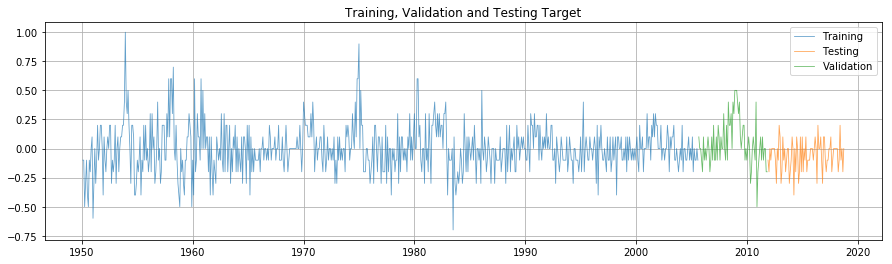

time: 268 ms


In [8]:
plt.figure(figsize=(15,4))
plt.plot(y_train, linewidth=0.8, alpha=0.7)
plt.plot(y_test, linewidth=0.8, alpha=0.7)
plt.plot(y_val, linewidth=0.8, alpha=0.7)
plt.grid(True)
plt.legend(["Training", "Testing", "Validation"], loc="best")
plt.title("Training, Validation and Testing Target")
plt.show()

In [9]:
INPUT_LAYER_SIZE = X_FEATURES
HIDDEN_LAYER_SIZE_1 = 512
HIDDEN_LAYER_SIZE_2 = 256
OUTPUT_LAYER_SIZE = 1
LEARNING_RATE = 0.003

EPOCHS = 1000
LOG_SEP = 10  # Log epoch seperation
REPORT_SEP = 100  # Report epoch seperation

time: 641 µs


In [10]:
with tf.variable_scope("inputs"):
    X = tf.placeholder(
        dtype=tf.float32,
        shape=[None, X_FEATURES],
        name="predictors")
    y_true = tf.placeholder(
        dtype=tf.float32,
        shape=[None, 1],
        name="Response"
    )

time: 13.1 ms


In [11]:
with tf.variable_scope("layers"):
    W1 = tf.Variable(tf.random_uniform(
        [INPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE_1], -1, 1))
    b1 = tf.Variable(tf.random_uniform(
        [HIDDEN_LAYER_SIZE_1], -1, 1))
    
    W2 = tf.Variable(tf.random_uniform(
        [HIDDEN_LAYER_SIZE_1, HIDDEN_LAYER_SIZE_2], -1 ,1))
    b2 = tf.Variable(tf.random_uniform(
        [HIDDEN_LAYER_SIZE_2], -1, 1))
    
    W3 = tf.Variable(tf.random_uniform(
        [HIDDEN_LAYER_SIZE_2, OUTPUT_LAYER_SIZE], -1, 1))
    b3 = tf.Variable(tf.random_uniform(
        [OUTPUT_LAYER_SIZE], -1, 1))

    # HL: Hidden Layer
    # AHL: Activated Hidden Layer
    HL_1 = tf.add(tf.matmul(X, W1), b1)
    AHL_1 = tf.sigmoid(HL_1)
    
    HL_2 = tf.add(
        tf.matmul(AHL_1, W2), b2)
    
    AHL_2 = tf.sigmoid(HL_2)
    
    output_layer = tf.add(tf.matmul(AHL_2, W3), b3)

    loss = tf.reduce_mean(tf.square(y_true - output_layer))

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

time: 144 ms


In [12]:
loss_history = {
    "epoch": list(),
    "train": list(),
    "val": list()
}

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for e in range(EPOCHS):
        sess.run(optimizer, feed_dict={
                    X: X_train.values,
                    y_true: y_train.values})
        
        if e % LOG_SEP == 0:
            train_loss = sess.run(loss, feed_dict={
                X: X_train.values,
                y_true: y_train.values
            })
            val_loss = sess.run(loss, feed_dict={
                X: X_val.values,
                y_true: y_val.values
            })
            loss_history["epoch"].append(e)
            loss_history["train"].append(train_loss)
            loss_history["val"].append(val_loss)
            
        if e % REPORT_SEP == 0:
            train_loss = sess.run(loss, feed_dict={
                X: X_train.values,
                y_true: y_train.values
            })
            val_loss = sess.run(loss, feed_dict={
                X: X_val.values,
                y_true: y_val.values
            })
            print(f"Epoch {e}: Training Loss :{train_loss:0.7f}, Validation Loss :{val_loss:0.7f}")
    train_loss = sess.run(loss, feed_dict={X: X_train.values, y_true: y_train.values})
    val_loss = sess.run(loss, feed_dict={X: X_val.values, y_true: y_val.values})
    print(f"Final: Training Loss :{train_loss:0.7f}, Validation Loss :{val_loss:0.7f}")
    
    pred_train = sess.run(output_layer, feed_dict={
        X: X_train.values,
        y_true: y_train.values
    })
    
    pred_val = sess.run(output_layer, feed_dict={
        X: X_val.values,
        y_true: y_val.values
    })

    pred_test = sess.run(output_layer, feed_dict={
        X: X_test.values,
        y_true: y_test.values
    })

Epoch 0: Training Loss :5.4091697, Validation Loss :4.9081321
Epoch 100: Training Loss :0.0816160, Validation Loss :0.0941696
Epoch 200: Training Loss :0.0407722, Validation Loss :0.0774752
Epoch 300: Training Loss :0.0249187, Validation Loss :0.0754487
Epoch 400: Training Loss :0.0171578, Validation Loss :0.0760085
Epoch 500: Training Loss :0.0129973, Validation Loss :0.0758072
Epoch 600: Training Loss :0.0104095, Validation Loss :0.0757443
Epoch 700: Training Loss :0.0085879, Validation Loss :0.0755251
Epoch 800: Training Loss :0.0072294, Validation Loss :0.0755046
Epoch 900: Training Loss :0.0061814, Validation Loss :0.0756313
Final: Training Loss :0.0053558, Validation Loss :0.0758267
time: 9.96 s


In [13]:
pred_train = pd.DataFrame(pred_train)
pred_train.set_index(y_train.index, inplace=True)

pred_val = pd.DataFrame(pred_val)
pred_val.set_index(y_val.index, inplace=True)

pred_test = pd.DataFrame(pred_test)
pred_test.set_index(y_test.index, inplace=True)

time: 1.58 ms


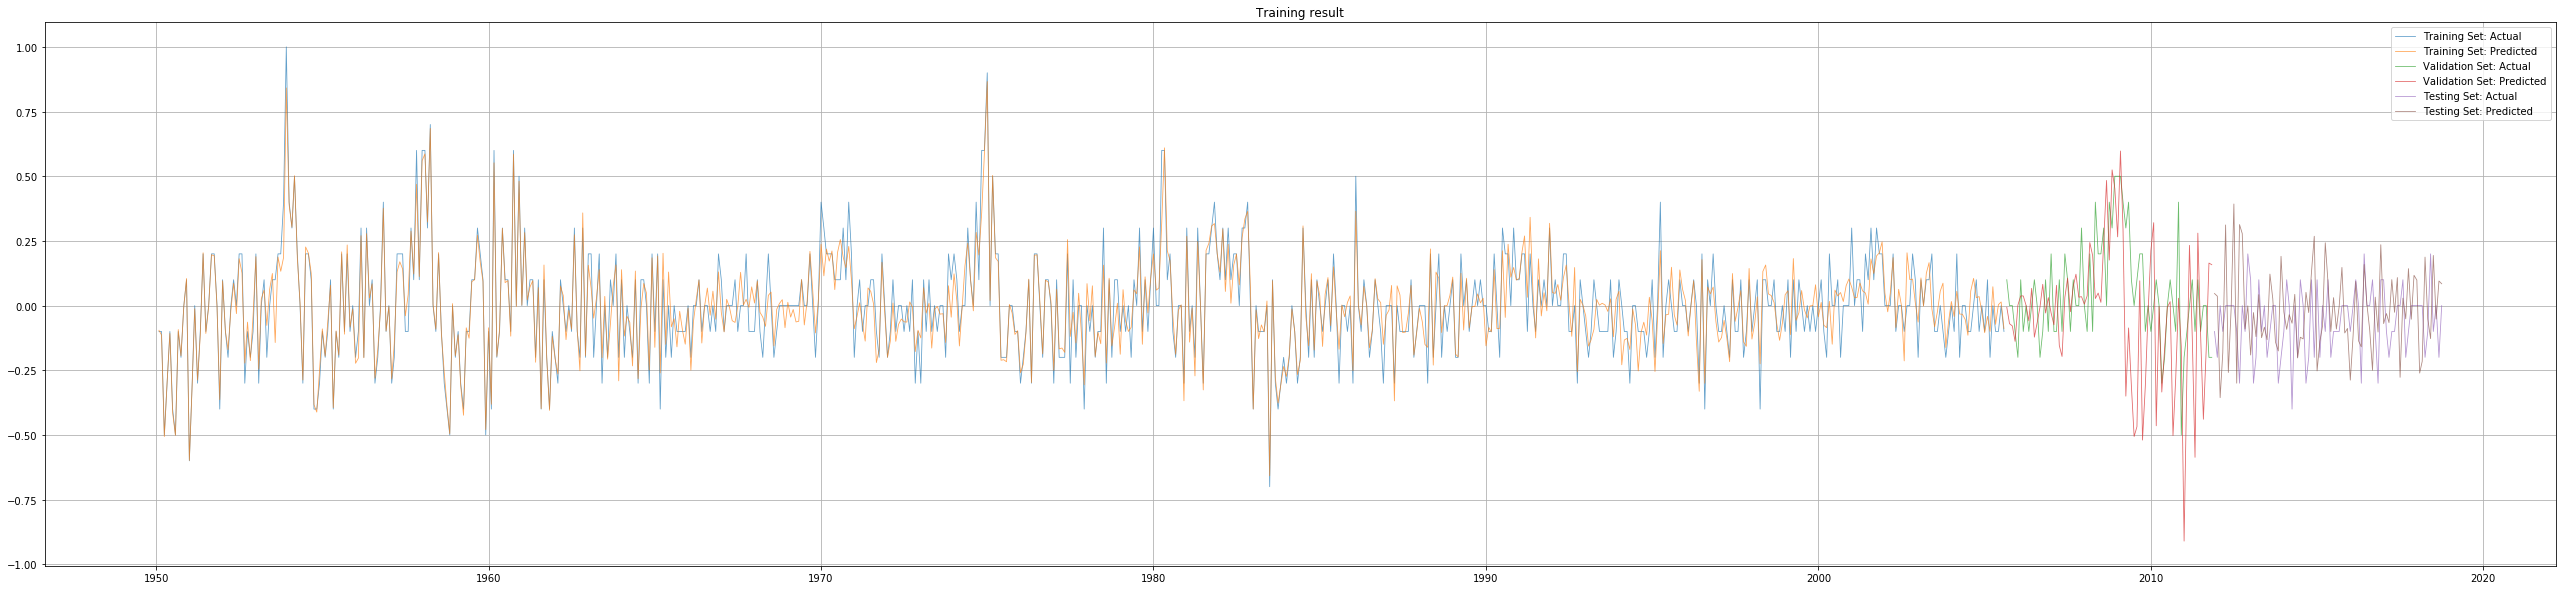

time: 708 ms


In [14]:
plt.close()
plt.figure(figsize=(45, 10))
for s in [y_train, pred_train,
          y_val, pred_val,
          y_test, pred_test]:
    plt.plot(s, linewidth=0.8, alpha=0.7)
plt.legend([
    "Training Set: Actual",
    "Training Set: Predicted",
    "Validation Set: Actual",
    "Validation Set: Predicted",
    "Testing Set: Actual",
    "Testing Set: Predicted"
])
plt.title("Training result")
plt.grid(True)
plt.show()

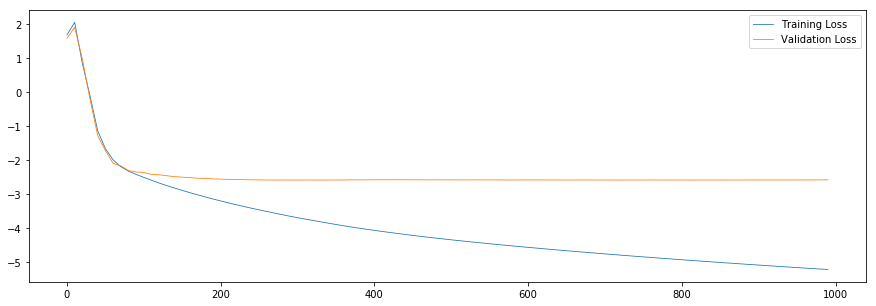

time: 205 ms


In [15]:
plt.close()
plt.figure(figsize=(15, 5))
plt.plot(loss_history["epoch"], np.log(loss_history["train"]), linewidth=0.8)
plt.plot(loss_history["epoch"], np.log(loss_history["val"]), linewidth=0.8)
plt.legend(["Training Loss", "Validation Loss"])
plt.show()